# FloPy

### Henry Saltwater Intrusion Problem

In this notebook, we will use Flopy to create, run, and post process the Henry saltwater intrusion problem using SEAWAT Version 4.

In [1]:
%matplotlib inline
import os
import sys
import numpy as np

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.6.4 | packaged by conda-forge | (default, Dec 23 2017, 16:54:01) 
[GCC 4.2.1 Compatible Apple LLVM 6.1.0 (clang-602.0.53)]
numpy version: 1.14.0
flopy version: 3.2.9


In [2]:
workspace = os.path.join('data')
#make sure workspace directory exists
if not os.path.exists(workspace):
    os.makedirs(workspace)

In [3]:
# Input variables for the Henry Problem
Lx = 2.
Lz = 1.
nlay = 50
nrow = 1
ncol = 100
delr = Lx / ncol
delc = 1.0
delv = Lz / nlay
henry_top = 1.
henry_botm = np.linspace(henry_top - delv, 0., nlay)
qinflow = 5.702  #m3/day
dmcoef = 0.57024 #m2/day  Could also try 1.62925 as another case of the Henry problem
hk = 864.  #m/day

In [4]:
# Create the basic MODFLOW model structure
modelname = 'henry'
swt = flopy.seawat.Seawat(modelname, exe_name='swtv4', model_ws=workspace)
print(swt.namefile)

# save cell fluxes to unit 53
ipakcb = 53

# Add DIS package to the MODFLOW model
dis = flopy.modflow.ModflowDis(swt, nlay, nrow, ncol, nper=1, delr=delr,
                               delc=delc, laycbd=0, top=henry_top,
                               botm=henry_botm, perlen=1.5, nstp=15)

# Variables for the BAS package
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[:, :, -1] = -1
bas = flopy.modflow.ModflowBas(swt, ibound, 0)

# Add LPF package to the MODFLOW model
lpf = flopy.modflow.ModflowLpf(swt, hk=hk, vka=hk, ipakcb=ipakcb)

# Add PCG Package to the MODFLOW model
pcg = flopy.modflow.ModflowPcg(swt, hclose=1.e-8)

# Add OC package to the MODFLOW model
oc = flopy.modflow.ModflowOc(swt, 
                             stress_period_data={(0, 0): ['save head', 'save budget']},
                             compact=True)

# Create WEL and SSM data
itype = flopy.mt3d.Mt3dSsm.itype_dict()
wel_data = {}
ssm_data = {}
wel_sp1 = []
ssm_sp1 = []
for k in range(nlay):
    wel_sp1.append([k, 0, 0, qinflow / nlay])
    ssm_sp1.append([k, 0, 0, 0., itype['WEL']])
    ssm_sp1.append([k, 0, ncol - 1, 35., itype['BAS6']])
wel_data[0] = wel_sp1
ssm_data[0] = ssm_sp1
wel = flopy.modflow.ModflowWel(swt, stress_period_data=wel_data, ipakcb=ipakcb)

henry.nam


In [5]:
# Create the basic MT3DMS model structure
#mt = flopy.mt3d.Mt3dms(modelname, 'nam_mt3dms', mf, model_ws=workspace)
btn = flopy.mt3d.Mt3dBtn(swt, nprs=-5, prsity=0.35, sconc=35., ifmtcn=0,
                         chkmas=False, nprobs=10, nprmas=10, dt0=0.001)
adv = flopy.mt3d.Mt3dAdv(swt, mixelm=0)
dsp = flopy.mt3d.Mt3dDsp(swt, al=0., trpt=1., trpv=1., dmcoef=dmcoef)
gcg = flopy.mt3d.Mt3dGcg(swt, iter1=500, mxiter=1, isolve=1, cclose=1e-7)
ssm = flopy.mt3d.Mt3dSsm(swt, stress_period_data=ssm_data)

# Create the SEAWAT model structure
#mswt = flopy.seawat.Seawat(modelname, 'nam_swt', mf, mt, model_ws=workspace, exe_name='swtv4')
vdf = flopy.seawat.SeawatVdf(swt, iwtable=0, densemin=0, densemax=0,
                             denseref=1000., denseslp=0.7143, firstdt=1e-3)

In [6]:
# Write the input files
#mf.write_input()
#mt.write_input()

swt.write_input()

In [7]:
# Try to delete the output files, to prevent accidental use of older files
try:
    os.remove(os.path.join(workspace, 'MT3D001.UCN'))
    os.remove(os.path.join(workspace, modelname + '.hds'))
    os.remove(os.path.join(workspace, modelname + '.cbc'))
except:
    pass

In [8]:
v = swt.run_model(silent=True, report=True)
for idx in range(-3, 0):
    print(v[1][idx])

 Elapsed run time: 11.022 Seconds

 Normal termination of SEAWAT


In [9]:
# Post-process the results
import numpy as np
import flopy.utils.binaryfile as bf

# Load data
ucnobj = bf.UcnFile(os.path.join(workspace, 'MT3D001.UCN'), model=swt)
times = ucnobj.get_times()
concentration = ucnobj.get_data(totim=times[-1])
cbbobj = bf.CellBudgetFile(os.path.join(workspace, 'henry.cbc'))
times = cbbobj.get_times()
qx = cbbobj.get_data(text='flow right face', totim=times[-1])[0]
qz = cbbobj.get_data(text='flow lower face', totim=times[-1])[0]

# Average flows to cell centers
qx_avg = np.empty(qx.shape, dtype=qx.dtype)
qx_avg[:, :, 1:] = 0.5 * (qx[:, :, 0:ncol-1] + qx[:, :, 1:ncol])
qx_avg[:, :, 0] = 0.5 * qx[:, :, 0]
qz_avg = np.empty(qz.shape, dtype=qz.dtype)
qz_avg[1:, :, :] = 0.5 * (qz[0:nlay-1, :, :] + qz[1:nlay, :, :])
qz_avg[0, :, :] = 0.5 * qz[0, :, :]

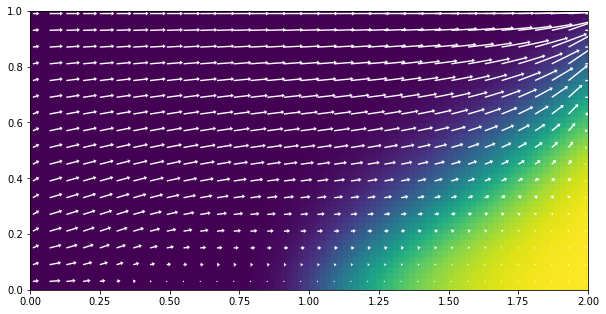

In [10]:
# Make the plot
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.imshow(concentration[:, 0, :], interpolation='nearest',
           extent=(0, Lx, 0, Lz))
y, x, z = dis.get_node_coordinates()
X, Z = np.meshgrid(x, z[:, 0, 0])
iskip = 3
ax.quiver(X[::iskip, ::iskip], Z[::iskip, ::iskip],
           qx_avg[::iskip, 0, ::iskip], -qz_avg[::iskip, 0, ::iskip],
           color='w', scale=5, headwidth=3, headlength=2,
           headaxislength=2, width=0.0025)
plt.savefig(os.path.join(workspace, 'henry.png'))
plt.show()

In [11]:
# Extract the heads
fname = os.path.join(workspace, 'henry.hds')
headobj = bf.HeadFile(fname)
times = headobj.get_times()
head = headobj.get_data(totim=times[-1])

Text(0.5,1,'Simulated Heads')

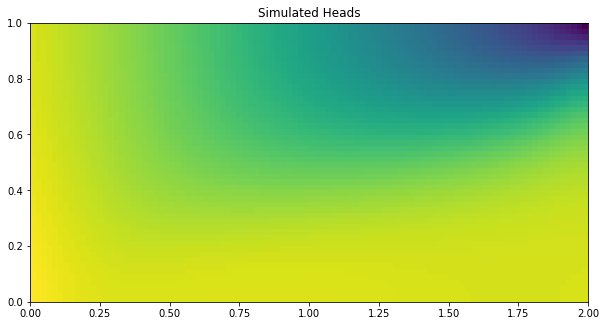

In [12]:
# Make a simple head plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
im = ax.imshow(head[:, 0, :], interpolation='nearest',
               extent=(0, Lx, 0, Lz))
ax.set_title('Simulated Heads')

#### Change the format of several arrays and rerun the model

In [13]:
swt.btn.prsity.how = "constant"
swt.btn.prsity[0].how = "internal"
swt.btn.prsity[1].how = "external"
swt.btn.sconc[0].how = "external"
swt.btn.prsity[0].fmtin = "(100E15.6)"
swt.lpf.hk[0].fmtin = "(BINARY)"

In [14]:
#mf.write_input()
#mt.write_input()
swt.write_input()
v = swt.run_model(silent=True, report=True)
for idx in range(-3, 0):
    print(v[1][idx])

Util2d:hk layer 1: resetting 'how' to external
 Elapsed run time: 11.525 Seconds

 Normal termination of SEAWAT
